# <ins>APPRENTISSAGE DES IMAGES AVEC EFFICIENTNETB1</ins>

## <ins>CHARGEMENT DES LIBRAIRIES</ins>

In [2]:
import numpy as np
import pandas as pd
import json
import math
from glob import glob
import pathlib
import os

import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
import h5py

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-05-04 21:03:38.915578: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 21:03:38.958019: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## <ins>CHARGEMENT DE NOTRE DATAFRAME APRES PREPROCESSING</ins>

In [3]:
df_train = pd.read_csv('train_df.csv', index_col=[0])
df_train.prdtypecode = df_train.prdtypecode.astype(str)
df_train.filepath = df_train.filepath.astype(str)
df_train.filepath = df_train.filepath.str.replace('/train/', '/pretraitement/train/')
df_test = pd.read_csv('test_df.csv', index_col=[0])
df_test.prdtypecode = df_test.prdtypecode.astype(str)
df_test.filepath = df_test.filepath.astype(str)
df_test.filepath = df_test.filepath.str.replace('/train/', '/pretraitement/train/')
display(df_train.head())
display(df_test.head())

,prdtypecode,filepath,produit_clean
20801,10,./images/pretraitement/train/image_1296257106_...,music journal notebook white paper edition
34711,2705,./images/pretraitement/train/image_1113907088_...,paris plus belle vacances liliane après opérat...
46725,1280,./images/pretraitement/train/image_890867971_p...,doudou lapin patapouf kaloo peluche boule bleu...
14558,1280,./images/pretraitement/train/image_1282020176_...,buyiesky®peluche hiver bottes neige american g...
3039,1160,./images/pretraitement/train/image_900656095_p...,foil premium collecteur âmes magic mtg fleau mint


,prdtypecode,filepath,produit_clean
81417,1320,./images/pretraitement/train/image_1319550229_...,papier jouet tortue tirer jouet enfants bricol...
650,2060,./images/pretraitement/train/image_1289199379_...,leopard cristal acrylique géométrique miroir a...
7055,1280,./images/pretraitement/train/image_1098949166_...,boite musique noël wish you merry christmas bo...
15371,1140,./images/pretraitement/train/image_1176785754_...,funko pop vinyl nfl jason witten cowboy
72558,2583,./images/pretraitement/train/image_1247849820_...,kit piscine acier aspect bois gré sicilia oval...


## <ins>GENERATEUR DE DONNEES</ins>

Les transformations appliquées sur notre image seront :

- une fonction de prétraitement du modèle EfficientNet : preprocess_input.
- création d'un dataset de validation de 20% du dataset train
- une rotation aléatoire sur une plage de 10 degrés.
- une translation verticale et horizontale sur une plage de 10% des dimensions de l'images.
- un agrandissement sur une plage 10% de l'image.
- un retournement aléatoire horizontal de l'image.

In [4]:
from tensorflow.keras.applications.efficientnet import preprocess_input

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input, validation_split = 0.10, rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.1, horizontal_flip = True)

test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

## <ins>CREATION DE NOS 3 DATASETS IMAGEDATAGENERATOR</ins>

#### <ins>ITERATEUR</ins>

Cette méthode permettra de charger les images, de générér pour chaque iteration des lots de données (batchs) transformé par le générateur d'images.

In [5]:
BATCH_SIZE = 20

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col = "filepath",
    y_col = "prdtypecode",
    target_size= (224,224),
    batch_size= BATCH_SIZE,
    class_mode= 'categorical',
    shuffle = True,
    subset = 'training'
    )

validation_generator = train_data_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col = "filepath",
    y_col = "prdtypecode",
    target_size= (224,224),
    batch_size= BATCH_SIZE,
    class_mode= 'categorical',
    shuffle = True,
    subset = 'validation'
    )

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col = "filepath",
    y_col = "prdtypecode",
    target_size= (224,224),
    batch_size= 1,
    class_mode= 'categorical',
    shuffle = False, 
    )

Found 51391 validated image filenames belonging to 27 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


Found 5710 validated image filenames belonging to 27 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


Found 19034 validated image filenames belonging to 27 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


##  <ins>CREATION DE NOTRE MODELE EFFICIENTNETB1 AVEC 7 COUCHES SUPPLEMENTAIRES</ins>

Le fait de mettre include_top = False equivaut à geler le poids des couches supérieurs  

In [7]:
base_model = tf.keras.applications.EfficientNetB1(input_shape = (224,224,3), include_top = False, weights = 'imagenet')

inp = Input(shape= (224,224,3))
x = base_model(inp)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.BatchNormalization(trainable = True,axis=1)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization(trainable = True, axis=1)(x)
outputs = tf.keras.layers.Dense(27, activation="softmax")(x)

model = Model(inputs = inp, outputs = outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb1 (Functional)     │ (None, 7, 7, 1280)     │     6,575,239 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 27)             │        13,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,431,778 (32.16 MB)

 Trainable params: 8,366,651 (31.92 MB)

 Non-trainable params: 65,127 (254.41 KB)

## <ins>COMPILATION - FONCTION PERTE SPARSE CATEGORIAL CROSSENTROPY - OPTIMIZER ADAM</ins>

In [8]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

## <ins>DERNIERES PREPARATION - CALLBACKS</ins>

In [9]:

save_best_models_path = "./sauvegarde_modele/effnetB1_freeze_cropped/modele_callback.weights.h5"

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
                    
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_best_models_path, save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min')
                     
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1,  mode='min')

# Entrainement

callbacks = [model_checkpoint, reduce_lr, earlystopping]

## <ins>FIT DU MODELE EFFICIENTNETB1</ins>

Nous partageons le jeu de données dataset_train entre l'entraînement et la validation, en utilisant les proportions 80% / 20%. Les variables steps_per_epoch et validation_steps servent à calculer le nombre exact d'itérations pour chaque phase durant chaque époque. Gardez en tête que dans ce cas, les mêmes échantillons seront utilisés aussi bien pour l'entraînement que pour la validation, ce qui pourrait introduire un biais si les deux phases étaient fortement corrélées. Mais dans la majorité des cas, cela n'engendrera pas de problème significatif.

In [10]:
# Fit le modèle avec les callbacks spécifiés
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1714857030.490114     788 service.cc:145] XLA service 0x7fc0e4002850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714857030.490166     788 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-05-04 21:10:31.742406: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-04 21:10:35.611030: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:171

 280/2570 ━━━━━━━━━━━━━━━━━━━━ 7:59 209ms/step - accuracy: 0.2356 - loss: 3.1427

I0000 00:00:1714857206.272776    1018 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_30235', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1714857206.698734    1015 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_29249', 4 bytes spill stores, 4 bytes spill loads



2570/2570 ━━━━━━━━━━━━━━━━━━━━ 831s 274ms/step - accuracy: 0.3521 - loss: 2.4012 - val_accuracy: 0.4504 - val_loss: 1.9286 - learning_rate: 0.0010
Epoch 2/10
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 552s 214ms/step - accuracy: 0.4743 - loss: 1.7940 - val_accuracy: 0.5040 - val_loss: 1.6899 - learning_rate: 0.0010
Epoch 3/10
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 552s 214ms/step - accuracy: 0.5158 - loss: 1.6394 - val_accuracy: 0.5275 - val_loss: 1.6492 - learning_rate: 0.0010
Epoch 4/10
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 557s 216ms/step - accuracy: 0.5434 - loss: 1.5283 - val_accuracy: 0.5522 - val_loss: 1.5130 - learning_rate: 0.0010
Epoch 5/10
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 547s 212ms/step - accuracy: 0.5696 - loss: 1.4411 - val_accuracy: 0.5359 - val_loss: 1.5850 - learning_rate: 0.0010
Epoch 6/10
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 552s 214ms/step - accuracy: 0.5911 - loss: 1.3462 - val_accuracy: 0.5800 - val_loss: 1.4532 - learning_rate: 0.0010
Epoch 7/10
2570/2570 ━━━━━━━━━━━━━━━━━━━━ 553s 214ms/step - acc

## <ins>SAUVEGARDE DE NOTRE MODELLE</ins>

In [11]:
# Chemin pour enregistrer le modèle
model_path = './sauvegarde_modele/effnetB1_freeze_cropped/effnetB1_freeze_cropped.keras'

# Enregistrement du modèle
model.save(model_path)

In [15]:
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 5.9 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Recupération des probabilités renvoyés par le modèke pour les 19034 images à 04:01:04


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19034/19034 ━━━━━━━━━━━━━━━━━━━━ 211s 10ms/step
Fin de la récupération à 04:04:42
Délai du modèle pour la prédiction :  0:03:38.106097
ACCURACY DU MODELE :  0.6110644110539035

F1_SCORE_WEIGHTED :  0.6049748907689618

              precision    recall  f1-score   support

          10       0.57      0.57      0.57       649
        1140       0.58      0.66      0.62       509
        1160       0.70      0.94      0.80       691
        1180       0.61      0.21      0.31       148
        1280       0.41      0.40      0.41      1105
        1281       0.34      0.32      0.33       499
        1300       0.66      0.67      0.67      1176
        1301       0.39      0.58      0.47       159
        1302       0.40      0.36      0.38       593
        1320       0.63      0.30      0.41       705
        1560       0.61      0.56      0.58      1298
        1920       0.67      0.85      0.75       988
        1940       0.74      0.58      0.65       172
        2060       0.41  

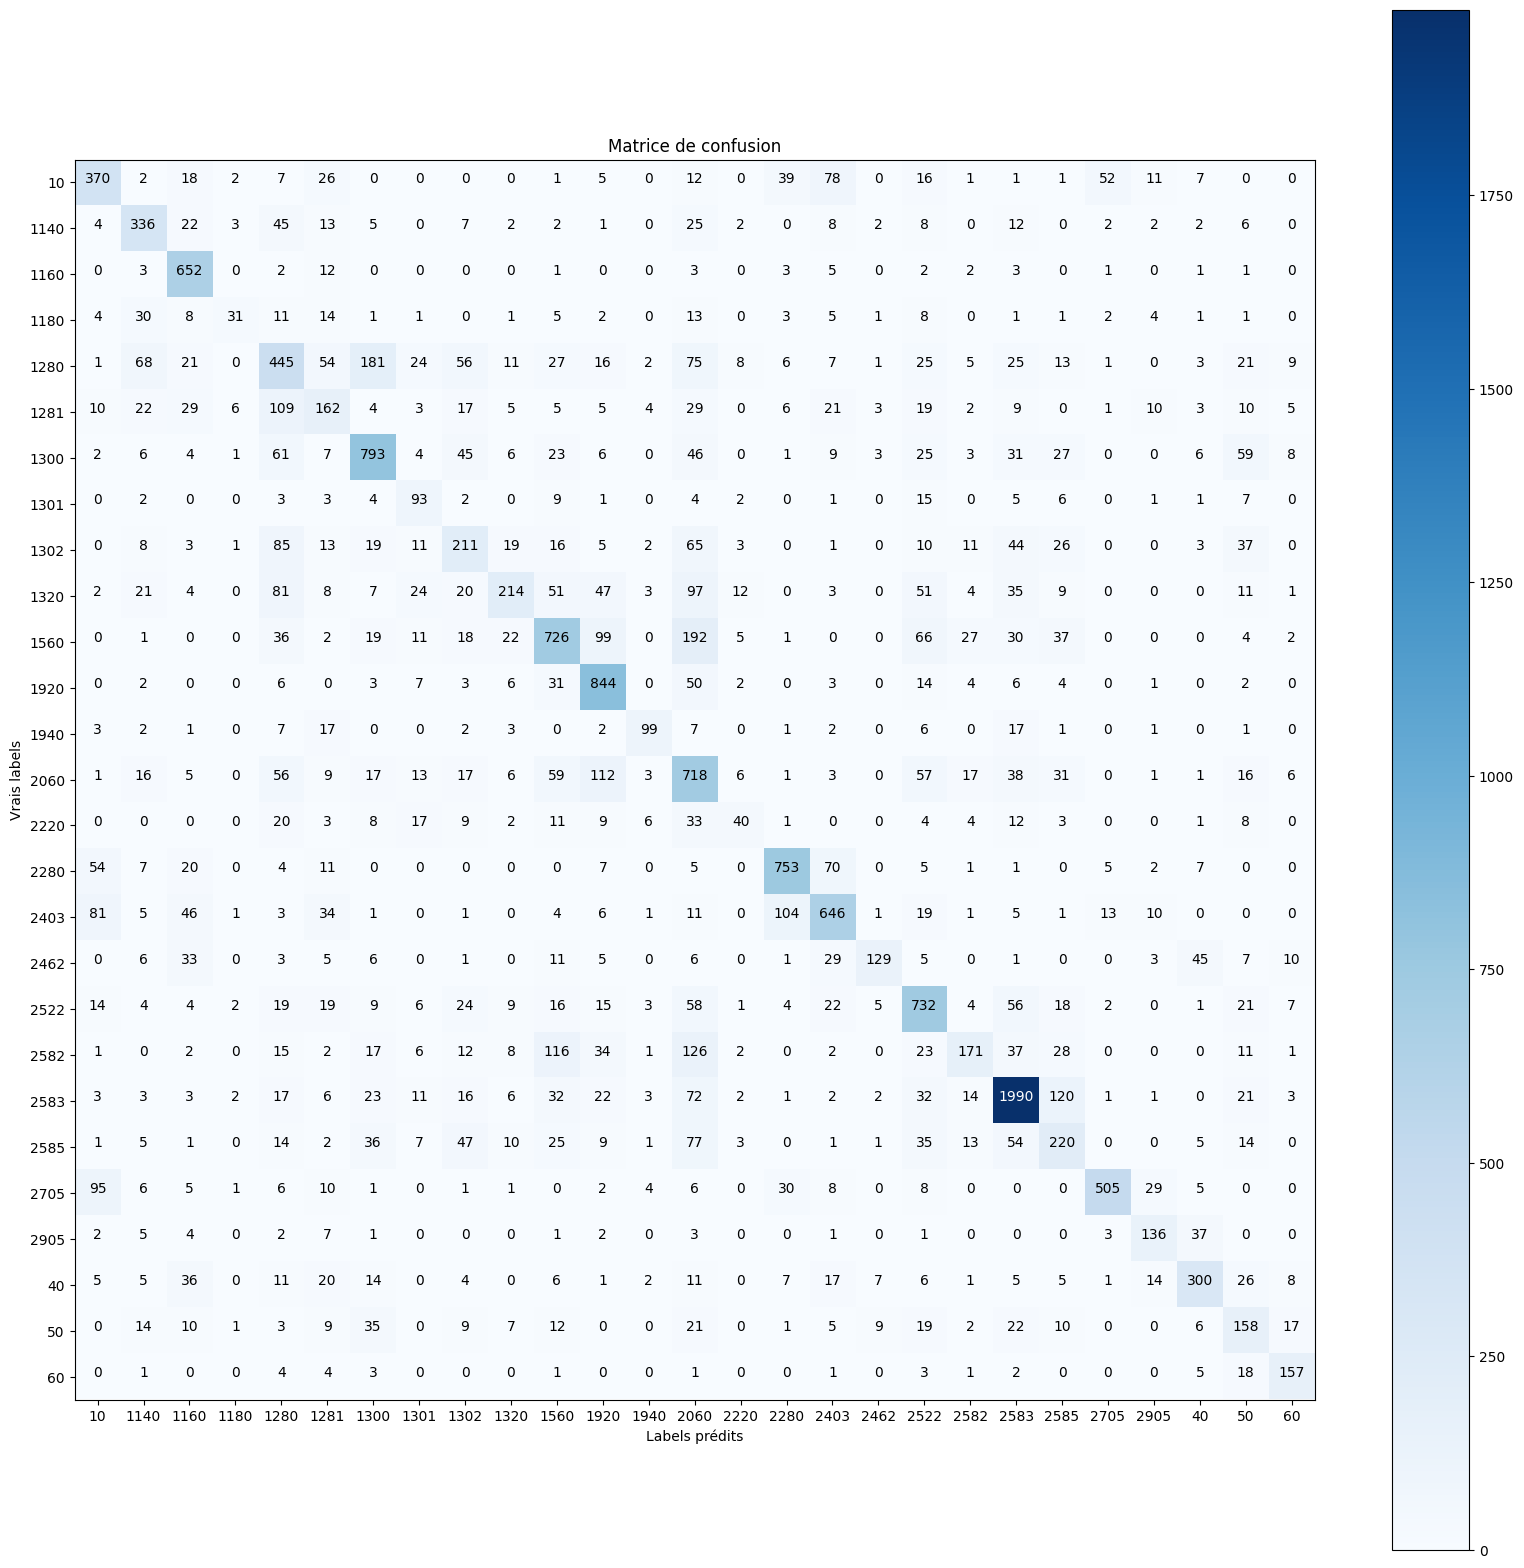

In [16]:
import projet_rakuten

from projet_rakuten import predict

y_prob, y_pred, y_test, class_labels = predict(test_generator, model)

## <ins>DE-FREEZ DES 8 DERNIERES COUCHES DE NOTRE MODELE EFFICIENTNET</ins>

In [17]:

save_best_models_path = "./sauvegarde_modele/effnetB1_unfreeze_cropped/modele_callback.weights.h5"

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
                    
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_best_models_path, save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min')
                     
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1,  mode='min')

# Entrainement

callbacks = [model_checkpoint, reduce_lr, earlystopping]

In [18]:
for layer in base_model.layers[-8:]:
    layer.trainable = True

lr = 0.0001
optimizer = Adam(learning_rate=lr)

# compile avec modification de l'optimizer
model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics = ['accuracy'])

# entrainement avec la méthode .fit()
history = model.fit(
    train_generator, 
    epochs = 10,
    validation_data = validation_generator,
    callbacks = callbacks)

Epoch 1/10


2024-05-05 05:22:27.723723: W external/local_tsl/tsl/framework/bfc_allocator.cc:487] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.0KiB (rounded to 4096)requested by op 
2024-05-05 05:22:27.725353: I external/local_tsl/tsl/framework/bfc_allocator.cc:1044] BFCAllocator dump for GPU_0_bfc
2024-05-05 05:22:27.725419: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (256): 	Total Chunks: 51786, Chunks in use: 51786. 12.64MiB allocated for chunks. 12.64MiB in use in bin. 230.5KiB client-requested in use in bin.
2024-05-05 05:22:27.725426: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (512): 	Total Chunks: 286, Chunks in use: 286. 181.5KiB allocated for chunks. 181.5KiB in use in bin. 146.9KiB client-requested in use in bin.
2024-05-05 05:22:27.725429: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (1024): 	Total Chunks: 152, Chunks in use: 152. 171.0KiB allocated for chunks. 171.0KiB in use in bin. 158.8KiB client-requested in use i

In [ ]:
# Chemin pour enregistrer le modèle
model_path = './sauvegarde_modele/effnetB1_unfreeze_cropped/effnetB1_unfreeze_cropped.keras'

# Enregistrement du modèle
model.save(model_path)

## <ins>PREDICTIONS ET SCORES</ins>

In [ ]:
import projet_rakuten

from projet_rakuten import predict

y_prob, y_pred, y_test, class_labels = predict(test_generator, model)